# Unit15_Appendix_distillation | Distillation Column: DNN predicts ethanol molar concentration

本 Notebook 使用 `Part_4/data/distillation_column/dataset_distill.csv` 建立回歸模型，預測產品端 **ethanol molar concentration**（欄位：`Ethanol concentration`）。

重點：
- 蒸餾塔多點溫度 + 流量資訊 -> 組成資料驅動 soft sensor
- Baseline（Ridge）vs DNN（MLP）性能比較
- 正確資料切分/標準化，避免 data leakage
- 訓練曲線、Parity/Residual plot 用於模型診斷


In [1]:
from __future__ import annotations

from pathlib import Path
import json
import os
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import joblib

warnings.filterwarnings('ignore', category=ConvergenceWarning)

# TensorFlow/Keras (optional). If not installed, use sklearn MLPRegressor.
TF_AVAILABLE = False
try:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers
    TF_AVAILABLE = True
except Exception:
    tf = None
    keras = None
    layers = None

SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
if TF_AVAILABLE:
    tf.random.set_seed(SEED)

NOTEBOOK_DIR = Path.cwd()
DATA_DIR = NOTEBOOK_DIR / 'data' / 'distillation_column'
OUTPUT_DIR = NOTEBOOK_DIR / 'outputs' / 'P4_Unit15_Appendix_Distillation'
FIG_DIR = OUTPUT_DIR / 'figs'
MODEL_DIR = OUTPUT_DIR / 'models'
for d in [OUTPUT_DIR, FIG_DIR, MODEL_DIR]:
    d.mkdir(parents=True, exist_ok=True)

DATA_PATH = DATA_DIR / 'dataset_distill.csv'

def savefig(name: str) -> Path:
    path = FIG_DIR / f'{name}.png'
    plt.savefig(path, dpi=160, bbox_inches='tight')
    print('Saved fig:', path)
    return path

print('Notebook dir:', NOTEBOOK_DIR)
print('Data path   :', DATA_PATH)
print('Output dir  :', OUTPUT_DIR)
print('Backend     :', 'tensorflow/keras' if TF_AVAILABLE else 'sklearn-mlp')
if TF_AVAILABLE:
    print('TensorFlow  :', tf.__version__)


Notebook dir: g:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials\Part_4
Data path   : g:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials\Part_4\data\distillation_column\dataset_distill.csv
Output dir  : g:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials\Part_4\outputs\P4_Unit15_Appendix_Distillation
Backend     : tensorflow/keras
TensorFlow  : 2.10.0


## 1) 讀取資料與欄位說明

資料欄位（單位依資料描述）：
- `Pressure`：塔壓 (bar)
- `T1`~`T14`：各塔板溫度 (K)
- `L`：Liquid flowrate
- `V`：Vapor flowrate
- `D`：Distillate flowrate
- `B`：Bottoms flowrate
- `F`：Feed flowrate
- `Ethanol concentration`：乙醇莫耳濃度 (target)

注意：原始 CSV 使用分號 `;` 作為分隔符號，且 `L`/`V` 欄位包含小數逗號科學記號（例如 `1,23E+08`），需先轉換為數值。


In [2]:
df = pd.read_csv(DATA_PATH, sep=';')
print('raw shape:', df.shape)
display(df.head())

# Convert L and V to numeric (decimal comma -> dot)
for col in ['L', 'V']:
    df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', '.', regex=False), errors='coerce')

print('dtypes:')
display(df.dtypes)
print('missing:')
display(df.isna().sum())

target_col = 'Ethanol concentration'
feature_cols = [c for c in df.columns if c != target_col]
print('n_features:', len(feature_cols), 'target:', target_col)
display(df[target_col].describe())


raw shape: (4408, 21)


,Pressure,T1,T2,T3,T4,T5,T6,T7,T8,T9,...,T11,T12,T13,T14,L,V,D,B,F,Ethanol concentration
0,1.01,350.89,350.95,351.01,351.08,351.16,351.26,351.38,351.54,351.78,...,353.00,355.19,363.77,371.47,780,1040,260,340,600,0.82076
1,1.01,350.86,350.91,350.96,351.02,351.09,351.17,351.28,351.43,351.66,...,352.76,354.66,362.20,370.98,780,1040,260,340,600,0.83253
2,1.01,350.85,350.89,350.93,350.99,351.05,351.13,351.23,351.37,351.58,...,352.55,354.13,360.16,370.10,780,1040,260,340,600,0.83953
3,1.01,350.84,350.88,350.92,350.97,351.03,351.11,351.21,351.34,351.53,...,352.40,353.75,358.45,368.99,780,1040,260,340,600,0.84366
4,1.01,350.83,350.87,350.91,350.96,351.02,351.09,351.18,351.31,351.49,...,352.30,353.50,357.23,367.81,780,1040,260,340,600,0.84622


dtypes:


Pressure                 float64
T1                       float64
T2                       float64
T3                       float64
T4                       float64
T5                       float64
T6                       float64
T7                       float64
T8                       float64
T9                       float64
T10                      float64
T11                      float64
T12                      float64
T13                      float64
T14                      float64
L                        float64
V                        float64
D                          int64
B                          int64
F                          int64
Ethanol concentration    float64
dtype: object

missing:


Pressure                 0
T1                       0
T2                       0
T3                       0
T4                       0
T5                       0
T6                       0
T7                       0
T8                       0
T9                       0
T10                      0
T11                      0
T12                      0
T13                      0
T14                      0
L                        0
V                        0
D                        0
B                        0
F                        0
Ethanol concentration    0
dtype: int64

n_features: 20 target: Ethanol concentration


count    4408.000000
mean        0.792205
std         0.076441
min         0.538190
25%         0.761890
50%         0.817520
75%         0.850280
max         0.891760
Name: Ethanol concentration, dtype: float64

## 2) EDA: 目標分佈與相關性（快速）

- 先看 `Ethanol concentration` 的分佈與尺度
- 再用 Pearson correlation 快速檢視線性關係（相關不等於因果）


Saved fig: g:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials\Part_4\outputs\P4_Unit15_Appendix_Distillation\figs\target_hist.png


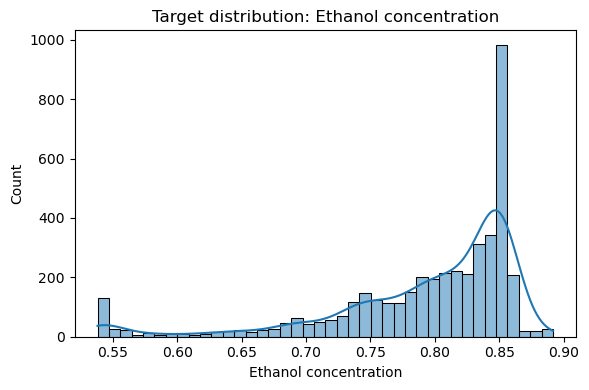

Ethanol concentration    1.000000
B                        0.320519
F                        0.272483
L                       -0.009334
V                       -0.009363
D                       -0.032578
T14                     -0.132484
T12                     -0.253807
T13                     -0.281439
T11                     -0.318123
T10                     -0.373304
T9                      -0.434553
T8                      -0.503237
T7                      -0.579956
T6                      -0.673202
T5                      -0.788148
T4                      -0.873145
T3                      -0.886038
T2                      -0.927970
T1                      -0.980998
Pressure                      NaN
Name: Ethanol concentration, dtype: float64

Saved fig: g:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials\Part_4\outputs\P4_Unit15_Appendix_Distillation\figs\corr_bar.png


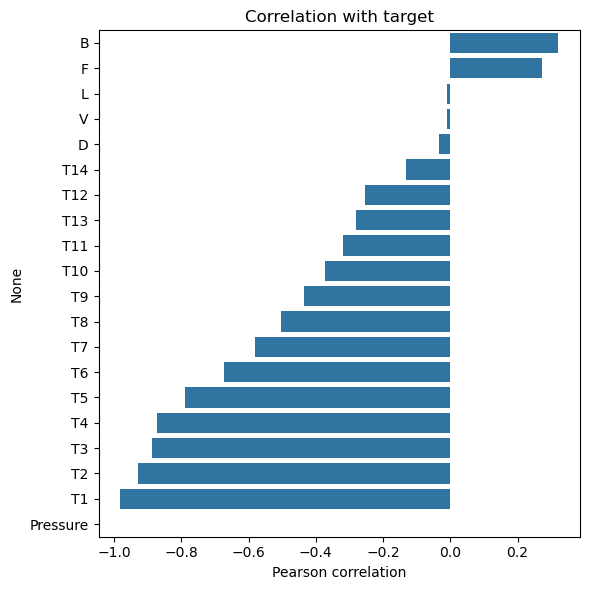

In [3]:
plt.figure(figsize=(6, 4))
sns.histplot(df[target_col], bins=40, kde=True)
plt.title('Target distribution: Ethanol concentration')
plt.xlabel(target_col)
plt.tight_layout()
savefig('target_hist')
plt.show()

corr = df[feature_cols + [target_col]].corr(numeric_only=True)[target_col].sort_values(ascending=False)
display(corr)

plt.figure(figsize=(6, 6))
sns.barplot(x=corr.drop(target_col).values, y=corr.drop(target_col).index, orient='h')
plt.title('Correlation with target')
plt.xlabel('Pearson correlation')
plt.tight_layout()
savefig('corr_bar')
plt.show()


## 3) Train/Valid/Test 切分與資料清理（避免 data leakage）

本範例採用 `train/valid/test = 70%/15%/15%`。

### 關於 L/V 欄位的極端值
資料中 `L`/`V` 會出現非常大的數值（例如 `1.23e8`、`1.23e9`）。若直接使用，可能造成尺度主導並降低模型穩定性。

示範做法：在訓練集上計算合理上限，並對 valid/test 套用相同上限做 clipping（只使用訓練集統計量，避免洩漏）。


In [4]:
X = df[feature_cols].to_numpy(dtype=np.float32)
y = df[target_col].to_numpy(dtype=np.float32)

X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=0.30, random_state=SEED)
X_valid, X_test, y_valid, y_test = train_test_split(X_tmp, y_tmp, test_size=0.50, random_state=SEED)

print('n_train:', X_train.shape[0], 'n_valid:', X_valid.shape[0], 'n_test:', X_test.shape[0])

# Clip extreme values for L and V based on train only
col_to_idx = {c: i for i, c in enumerate(feature_cols)}
lv_cols = ['L', 'V']
caps = {}
for c in lv_cols:
    idx = col_to_idx[c]
    train_vals = X_train[:, idx]
    # define a conservative cap: max value below 1e6
    below = train_vals[train_vals < 1e6]
    cap = float(below.max()) if below.size else float(np.quantile(train_vals, 0.99))
    caps[c] = cap
    for arr in [X_train, X_valid, X_test]:
        arr[:, idx] = np.clip(arr[:, idx], a_min=None, a_max=cap)
print('L/V caps:', caps)


n_train: 3085 n_valid: 661 n_test: 662
L/V caps: {'L': 22500.0, 'V': 22650.0}


## 4) 標準化與 Baseline: Ridge Regression

- `StandardScaler` 只對訓練集 `fit`
- Ridge 作為線性 baseline，方便比較 DNN 是否真的帶來提升


In [5]:
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_valid_s = scaler.transform(X_valid)
X_test_s = scaler.transform(X_test)

ridge = Ridge(alpha=1.0)
ridge.fit(X_train_s, y_train)
pred_ridge = ridge.predict(X_test_s)

mae_r = float(mean_absolute_error(y_test, pred_ridge))
rmse_r = float(np.sqrt(mean_squared_error(y_test, pred_ridge)))
r2_r = float(r2_score(y_test, pred_ridge))

print(f'Ridge  MAE : {mae_r:.6f}')
print(f'Ridge RMSE : {rmse_r:.6f}')
print(f'Ridge R2  : {r2_r:.6f}')


Ridge  MAE : 0.004795
Ridge RMSE : 0.007037
Ridge R2  : 0.992161


## 5) DNN (MLP) 回歸模型

本範例提供兩種 backend：
- 若環境有 TensorFlow/Keras：使用 Keras MLP + EarlyStopping
- 否則：使用 sklearn `MLPRegressor` + warm_start 模擬 epoch + early stopping


In [18]:
def build_model(input_dim: int):
    if TF_AVAILABLE:
        model = keras.Sequential([
            layers.Input(shape=(input_dim,)),
            layers.Dense(128, activation='relu'),
            layers.Dense(64, activation='relu'),
            layers.Dense(32, activation='relu'),
            layers.Dense(1),
        ])
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=1e-3),
            loss='huber',
            metrics=[keras.metrics.MeanAbsoluteError(name='mae')],
        )
        return model

    return MLPRegressor(
        hidden_layer_sizes=(128, 64, 32),
        activation='relu',
        solver='adam',
        alpha=1e-4,
        batch_size=64,
        learning_rate_init=1e-3,
        max_iter=1,
        warm_start=True,
        shuffle=True,
        random_state=SEED,
    )

model = build_model(input_dim=X_train_s.shape[1])
if TF_AVAILABLE:
    model.summary()
else:
    print(model)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 128)               2688      
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 dense_14 (Dense)            (None, 32)                2080      
                                                                 
 dense_15 (Dense)            (None, 1)                 33        
                                                                 
Total params: 13,057
Trainable params: 13,057
Non-trainable params: 0
_________________________________________________________________


In [19]:
if TF_AVAILABLE:
    callbacks = [
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=10, factor=0.5, min_lr=1e-6),
    ]
    history = model.fit(
        X_train_s, y_train,
        validation_data=(X_valid_s, y_valid),
        epochs=500, batch_size=64, callbacks=callbacks, verbose=1
    )
else:
    train_losses = []
    val_losses = []
    best_val = float('inf')
    best_state = None
    patience = 30
    wait = 0
    max_epochs = 500
    for epoch in range(1, max_epochs + 1):
        model.fit(X_train_s, y_train)
        pred_train = model.predict(X_train_s)
        pred_valid = model.predict(X_valid_s)
        train_loss = float(mean_squared_error(y_train, pred_train))
        val_loss = float(mean_squared_error(y_valid, pred_valid))
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        if epoch == 1 or epoch % 25 == 0:
            print(f'epoch={epoch:4d} train_loss={train_loss:.6f} val_loss={val_loss:.6f}')
        if val_loss < best_val - 1e-9:
            best_val = val_loss
            wait = 0
            best_state = ([w.copy() for w in model.coefs_], [b.copy() for b in model.intercepts_])
        else:
            wait += 1
        if wait >= patience:
            print(f'Early stopping at epoch={epoch}, best val_loss={best_val:.6f}')
            break
    if best_state is not None:
        model.coefs_, model.intercepts_ = best_state
    history = {'loss': train_losses, 'val_loss': val_losses}


Epoch 1/500
49/49 [==============================] - 1s 9ms/step - loss: 0.0372 - mae: 0.1745 - val_loss: 0.0018 - val_mae: 0.0436 - lr: 0.0010
Epoch 2/500
49/49 [==============================] - 0s 5ms/step - loss: 9.1359e-04 - mae: 0.0289 - val_loss: 4.8059e-04 - val_mae: 0.0195 - lr: 0.0010
Epoch 3/500
49/49 [==============================] - 0s 5ms/step - loss: 3.4102e-04 - mae: 0.0161 - val_loss: 2.2750e-04 - val_mae: 0.0127 - lr: 0.0010
Epoch 4/500
49/49 [==============================] - 0s 6ms/step - loss: 1.7035e-04 - mae: 0.0110 - val_loss: 1.3579e-04 - val_mae: 0.0094 - lr: 0.0010
Epoch 5/500
49/49 [==============================] - 0s 6ms/step - loss: 1.0076e-04 - mae: 0.0087 - val_loss: 8.4240e-05 - val_mae: 0.0085 - lr: 0.0010
Epoch 6/500
49/49 [==============================] - 0s 5ms/step - loss: 6.5122e-05 - mae: 0.0073 - val_loss: 5.2095e-05 - val_mae: 0.0065 - lr: 0.0010
Epoch 7/500
49/49 [==============================] - 0s 5ms/step - loss: 4.8936e-05 - mae: 0.006

Saved fig: g:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials\Part_4\outputs\P4_Unit15_Appendix_Distillation\figs\loss_curve.png


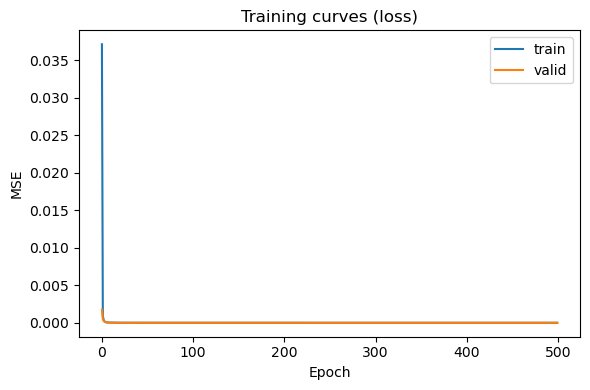

In [20]:
if TF_AVAILABLE:
    hist = pd.DataFrame(history.history)
else:
    hist = pd.DataFrame(history)

plt.figure(figsize=(6, 4))
plt.plot(hist['loss'], label='train')
plt.plot(hist['val_loss'], label='valid')
plt.title('Training curves (loss)')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.tight_layout()
savefig('loss_curve')
plt.show()


## 6) 評估: MAE / RMSE / R2 + Parity/Residual plots


In [21]:
if TF_AVAILABLE:
    pred_dnn = model.predict(X_test_s, verbose=0).reshape(-1)
else:
    pred_dnn = model.predict(X_test_s).reshape(-1)

mae = float(mean_absolute_error(y_test, pred_dnn))
rmse = float(np.sqrt(mean_squared_error(y_test, pred_dnn)))
r2 = float(r2_score(y_test, pred_dnn))

print(f'DNN   MAE : {mae:.6f}')
print(f'DNN  RMSE : {rmse:.6f}')
print(f'DNN   R2  : {r2:.6f}')

print()
print('(比較) Ridge baseline')
print(f'Ridge MAE : {mae_r:.6f}')
print(f'Ridge RMSE: {rmse_r:.6f}')
print(f'Ridge R2  : {r2_r:.6f}')

metrics = {
    'backend': 'tensorflow/keras' if TF_AVAILABLE else 'sklearn-mlp',
    'n_train': int(X_train_s.shape[0]),
    'n_valid': int(X_valid_s.shape[0]),
    'n_test': int(X_test_s.shape[0]),
    'lv_caps': caps,
    'ridge': {'mae': mae_r, 'rmse': rmse_r, 'r2': r2_r},
    'dnn': {'mae': mae, 'rmse': rmse, 'r2': r2},
}
metrics_path = OUTPUT_DIR / 'metrics.json'
metrics_path.write_text(json.dumps(metrics, ensure_ascii=False, indent=2), encoding='utf-8')
print()
print('Saved metrics:', metrics_path)


DNN   MAE : 0.001837
DNN  RMSE : 0.003255
DNN   R2  : 0.998323

(比較) Ridge baseline
Ridge MAE : 0.004795
Ridge RMSE: 0.007037
Ridge R2  : 0.992161

Saved metrics: g:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials\Part_4\outputs\P4_Unit15_Appendix_Distillation\metrics.json


Saved fig: g:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials\Part_4\outputs\P4_Unit15_Appendix_Distillation\figs\parity_plot.png


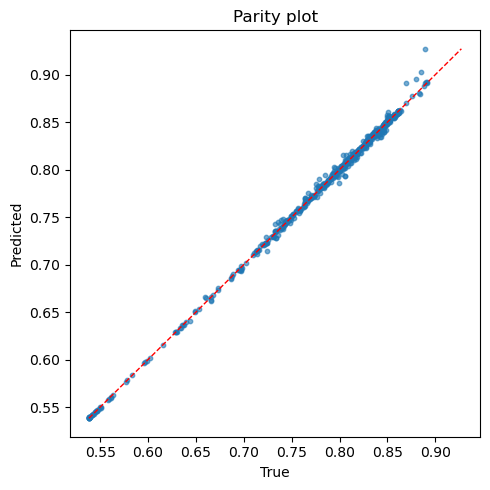

Saved fig: g:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials\Part_4\outputs\P4_Unit15_Appendix_Distillation\figs\residual_plot.png


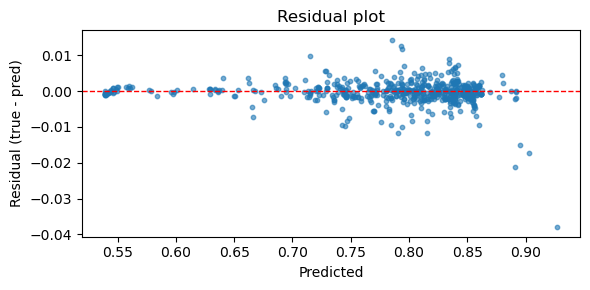

In [23]:
plt.figure(figsize=(5, 5))
plt.scatter(y_test, pred_dnn, s=10, alpha=0.6)
min_v = float(min(y_test.min(), pred_dnn.min()))
max_v = float(max(y_test.max(), pred_dnn.max()))
plt.plot([min_v, max_v], [min_v, max_v], 'r--', linewidth=1)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Parity plot')
plt.tight_layout()
savefig('parity_plot')
plt.show()

residual = y_test - pred_dnn
plt.figure(figsize=(6, 3))
plt.scatter(pred_dnn, residual, s=10, alpha=0.6)
plt.axhline(0, color='r', linestyle='--', linewidth=1)
plt.xlabel('Predicted')
plt.ylabel('Residual (true - pred)')
plt.title('Residual plot')
plt.tight_layout()
savefig('residual_plot')
plt.show()


## 7) 預測分佈與特徵關係 (sanity check)

這裡用 holdout test set 做視覺化：
- `y_test` 的真實分佈 vs `pred_dnn` 預測分佈
- 預測值 vs 關鍵特徵 (例如 Pressure, T14)


Saved fig: g:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials\Part_4\outputs\P4_Unit15_Appendix_Distillation\figs\test_true_vs_pred_dist.png


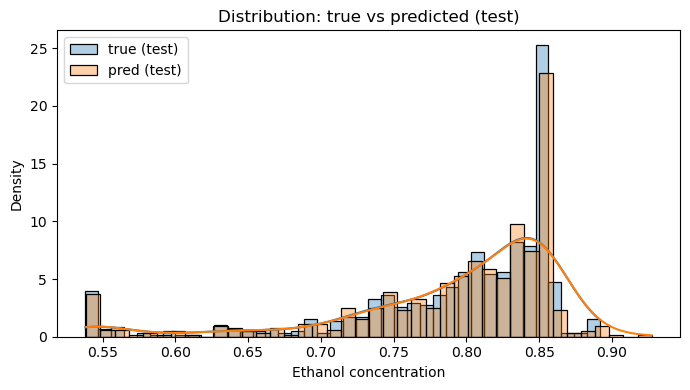

Saved fig: g:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials\Part_4\outputs\P4_Unit15_Appendix_Distillation\figs\test_pred_scatter.png


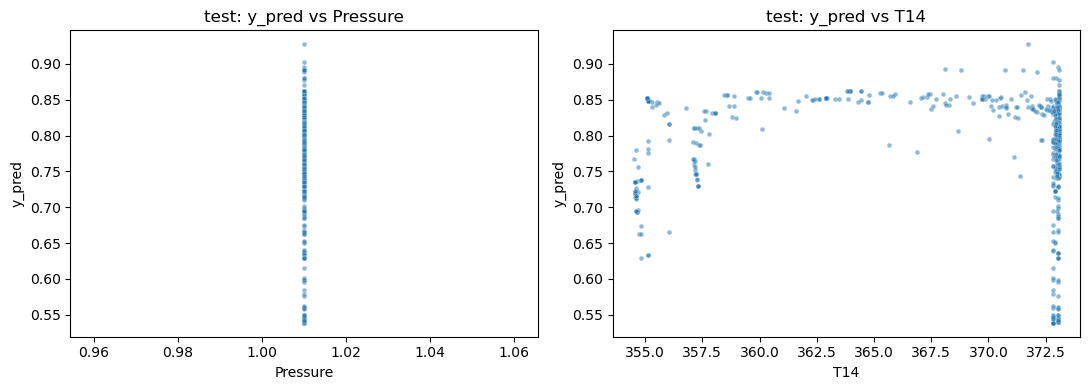

In [24]:
plt.figure(figsize=(7, 4))
sns.histplot(y_test, bins=40, stat='density', kde=True, color='C0', label='true (test)', alpha=0.35)
sns.histplot(pred_dnn, bins=40, stat='density', kde=True, color='C1', label='pred (test)', alpha=0.35)
plt.title('Distribution: true vs predicted (test)')
plt.xlabel(target_col)
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
savefig('test_true_vs_pred_dist')
plt.show()

test_df = pd.DataFrame(X_test, columns=feature_cols)
test_df['y_true'] = y_test
test_df['y_pred'] = pred_dnn

fig, axes = plt.subplots(1, 2, figsize=(11, 4))
sns.scatterplot(data=test_df, x='Pressure', y='y_pred', s=12, alpha=0.5, ax=axes[0])
axes[0].set_title('test: y_pred vs Pressure')
axes[0].set_xlabel('Pressure')
axes[0].set_ylabel('y_pred')

x_col = 'T14' if 'T14' in test_df.columns else 'T1'
sns.scatterplot(data=test_df, x=x_col, y='y_pred', s=12, alpha=0.5, ax=axes[1])
axes[1].set_title(f'test: y_pred vs {x_col}')
axes[1].set_xlabel(x_col)
axes[1].set_ylabel('y_pred')

plt.tight_layout()
savefig('test_pred_scatter')
plt.show()


## 8) 保存模型與 scaler


In [25]:
if TF_AVAILABLE:
    model_path = MODEL_DIR / 'ethanol_dnn.keras'
    model.save(model_path)
else:
    model_path = MODEL_DIR / 'ethanol_mlp.joblib'
    joblib.dump(model, model_path)
print('Saved model:', model_path)

scaler_path = MODEL_DIR / 'scaler.joblib'
joblib.dump(scaler, scaler_path)
print('Saved scaler:', scaler_path)


Saved model: g:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials\Part_4\outputs\P4_Unit15_Appendix_Distillation\models\ethanol_dnn.keras
Saved scaler: g:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials\Part_4\outputs\P4_Unit15_Appendix_Distillation\models\scaler.joblib
